<a href="https://colab.research.google.com/github/Kamil111-pl/GenAi/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How an LLM Generates Text**

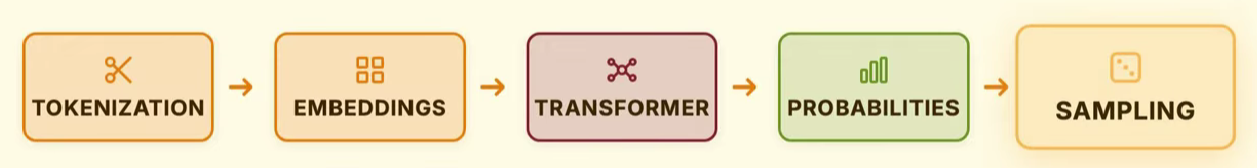

In [ ]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 4.2 MB/s eta 0:00:00


# **torch**

This is **PyTorch**, the deep learning framework. It contains support for:

* Tensors, which are similar to nD arrays but much faster with GPU support
* Neural network layers
* GPU acceleration, when/if available
* LLMs, which cannot run without libraries such as PyTorch

# **transformers**

* The Hugging Face Transformers library contains:
  * Pretrained models such as GPT-2, BERT, etc.
  * Tokenizers
  * Model architectures
  * Loading & inference APIs
  * Without this library, we  would have to implement the transformer architecture, load model weights manually, write tokenizers from scratch, etc.

In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT


In [ ]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# **Example**


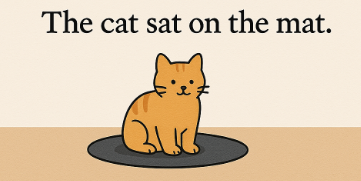

In [ ]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: The Mclarens Formula 1 engine screamed during a race at Monaco and 


In [ ]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


Token IDs: [464, 337, 565, 5757, 82, 19639, 352, 3113, 25421, 1141, 257, 3234, 379, 31630, 290, 220]
Tokens:
   464 → 'The'
   337 → ' M'
   565 → 'cl'
  5757 → 'aren'
    82 → 's'
 19639 → ' Formula'
   352 → ' 1'
  3113 → ' engine'
 25421 → ' screamed'
  1141 → ' during'
   257 → ' a'
  3234 → ' race'
   379 → ' at'
 31630 → ' Monaco'
   290 → ' and'
   220 → ' '


In [ ]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([1, 16, 768])


In [ ]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)


Hidden state shape: torch.Size([1, 16, 768])


In [ ]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)


Logits shape: torch.Size([1, 50257])


In [ ]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


Top 10 next-token probabilities:
      '\xa0' : 0.4849
      'iced' : 0.1384
'________________' : 0.0263
  '________' : 0.0222
       'ich' : 0.0204
       'urn' : 0.0177
       '!!!' : 0.0175
       'ick' : 0.0135
         'Â' : 0.0131
      'icky' : 0.0125


In [ ]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=2.0, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=2.0, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))


Sampled token: ________________________________


In [ ]:
# Trial A - Temperature 0.1

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.1, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=10)




The Mclarens Formula 1 engine screamed during a race at Monaco and  
The Mclarens Formula 1 engine screamed during a race at Monaco and  the
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced to
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced to cancel
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced to cancel the
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced to cancel the race
The Mclarens Formula 1 engine screamed during a race at Monaco and  the team was forced to cancel the race after


In [ ]:
#Trial B - Temperature 0.8

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.8, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=10)


The Mclarens Formula 1 engine screamed during a race at Monaco and  
The Mclarens Formula 1 engine screamed during a race at Monaco and  the
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to be
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to be stopped
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to be stopped was
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to be stopped was Fernando
The Mclarens Formula 1 engine screamed during a race at Monaco and  the first driver to be stopped was Fernando Alonso


In [ ]:
# Full loop (generate multiple tokens)
# Trial C - Temperature 2.0

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=2.0, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=10)


The Mclarens Formula 1 engine screamed during a race at Monaco and  
The Mclarens Formula 1 engine screamed during a race at Monaco and  in
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won 24
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won 24 points
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won 24 points off
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won 24 points off the
The Mclarens Formula 1 engine screamed during a race at Monaco and  in 2012 he won 24 points off the top


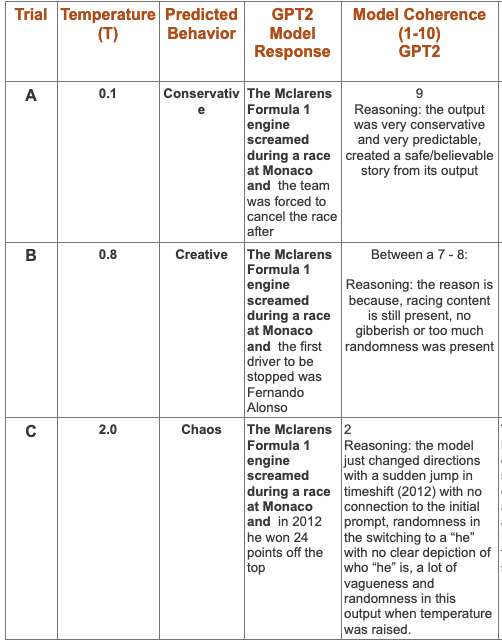

# **Analysis**
In this stress test using the GPT2 model, the prompt that was used under this trial was:

Prompt: The Mclarens Formula 1 engine screamed during a race at Monaco and

Based on this prompt I ran 3 trials using the same prompt but with a varied temperature on each trial, Trial A(temp = 0.1), Trial B(temp = 0.8), and Trial C where the temperature was 2.0.

# **Did your model repeat any words or phrases?**
 * Trial A: The model was conservative the continuation flowed naturally in its output
 * Trial B: Output still stayed coherent in its natural flow, everything flowed naturally in its continuation from the initial prompt, additional information was given such as introducing F1 Driver Fernando Alonso. Overall creativity and natural flow was impressive.
 * Trial C: Randomness begins during this stage, irrelevant information appeared, or information with no relevant context also appeared during this stage.


# **Did the model use real words, or did it start outputting random characters and punctuation? Explain how the "Probability Distribution" changed to allow this.**
* At Trial A and B, coherence was sharp, based on this probability distribution also stayed sharp as the model was able to pick highly probable tokens related to racing most of the time during these temperature ranges.
* At Trial C we can assume that when logits were divided by 2.0, it flattened the probability distribution as during this stage it picked low probability tokens that gave the output higher randomness/chaos such as the introduction of random years in its output (2012), random stats (24), random gender pronouns with no meaning to the prompt. Based on this a higher temperature will have trade offs, lack of coherence but far more diversity.


# **If you were building a medical AI to give prescriptions or advice, which temperature would you use?**
If I were to build a medical AI to give prescriptions or advice I would use a low temperature of 0.1 as a medical field needs consistent, correct and reliable outputs. Having a high temperature would result in creativity. In the medical field we do not want a creative model, we want a consistent, reliable model. Having a lower temperature would allow the model to output most likely answers not creative ones, after all a patient's life is at risk.


# **If you were building an AI to write a surrealist dream-journal, which would you use?**
If I was building an AI to write a surrealist dream journal, I would use a model with a high temperature as a surrealist dream journal is supposed to have creativity, with a temperature of  1.3 - 2.0, as an example in this experiment spiking a high temperature promotes randomness, by giving a prompt to steer the AI models latent space to have it focus on surrealist dream, a high temperature would spark creativity in the model.



# **Extra Credit using Distillation**
By using the basic logic from above, the model was swapped from the GPT 2 model to a DistilGPT2 to run 3 Trials:

Trial A using DistilGPT2 with a temperature of 0.1 to measure the models coherence

Trial B using DistilGPT2 with a temperature of 0.8 to measure the models coherence

Trial C using DistilGPT2 with a temperature of 2.0 to measure the models coherence

At the end comparisons will be made against the GPT2 model and the DistilGPT2 model to measure how much of a difference in coherence these 2 models are.

In [ ]:
# Extra credit, first load the distilgpt2 model
from transformers import GPT2Tokenizer, GPT2LMHeadModel

distiltokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
distilmodel = GPT2LMHeadModel.from_pretrained("distilgpt2")
distilmodel.eval()



GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
prompt = "The Mclarens Formula 1 engine screamed during a race at Monaco and "

In [ ]:
#Trial A - Temperature 0.1 with DistilGPT2

def generate_with_distil(prompt, steps=10, temperature=0.1, top_k=40):
  tokens = distiltokenizer.encode(prompt, return_tensors="pt")
  for _ in range(steps):
    with torch.no_grad():
      outputs = distilmodel(tokens)
      logits = outputs.logits[:, -1, :]
      next_token = sample_next_token(logits, temperature=0.1, top_k=top_k)

    tokens = torch.cat([tokens, next_token], dim=1)
    print(distiltokenizer.decode(tokens[0]))

generate_with_distil(prompt, steps=10, temperature=0.1, top_k=40)


The Mclarens Formula 1 engine screamed during a race at Monaco and iced
The Mclarens Formula 1 engine screamed during a race at Monaco and iced up
The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the
The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine
The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.
The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.

The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.


The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.



The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.




The Mclarens Formula 1 engine screamed during a race at Monaco and iced up the engine.







In [ ]:

#Trial B - Temperature 0.8 with DistilGPT2

def generate_with_distil(prompt, steps=10, temperature=0.8, top_k=40):
  tokens = distiltokenizer.encode(prompt, return_tensors="pt")
  for _ in range(steps):
    with torch.no_grad():
      outputs = distilmodel(tokens)
      logits = outputs.logits[:, -1, :]
      next_token = sample_next_token(logits, temperature=0.8, top_k=top_k)

    tokens = torch.cat([tokens, next_token], dim=1)
    print(distiltokenizer.decode(tokens[0]))

generate_with_distil(prompt, steps=10, temperature=0.8, top_k=40)




The Mclarens Formula 1 engine screamed during a race at Monaco and iced
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the ground
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the ground.
The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the ground.

The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the ground.


The Mclarens Formula 1 engine screamed during a race at Monaco and iced the engine to the ground.





In [ ]:
#Trial C - Temperature 2.0 with DistilGPT2

def generate_with_distil(prompt, steps=10, temperature=2.0, top_k=40):
  tokens = distiltokenizer.encode(prompt, return_tensors="pt")
  for _ in range(steps):
    with torch.no_grad():
      outputs = distilmodel(tokens)
      logits = outputs.logits[:, -1, :]
      next_token = sample_next_token(logits, temperature=2.0, top_k=top_k)

    tokens = torch.cat([tokens, next_token], dim=1)
    print(distiltokenizer.decode(tokens[0]))

generate_with_distil(prompt, steps=10, temperature=2.0, top_k=40)

The Mclarens Formula 1 engine screamed during a race at Monaco and iced
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel for
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel for only
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel for only a
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel for only a second
The Mclarens Formula 1 engine screamed during a race at Monaco and iced with Red Bull fuel for only a second.


# **Analysis for DistilGPT2**

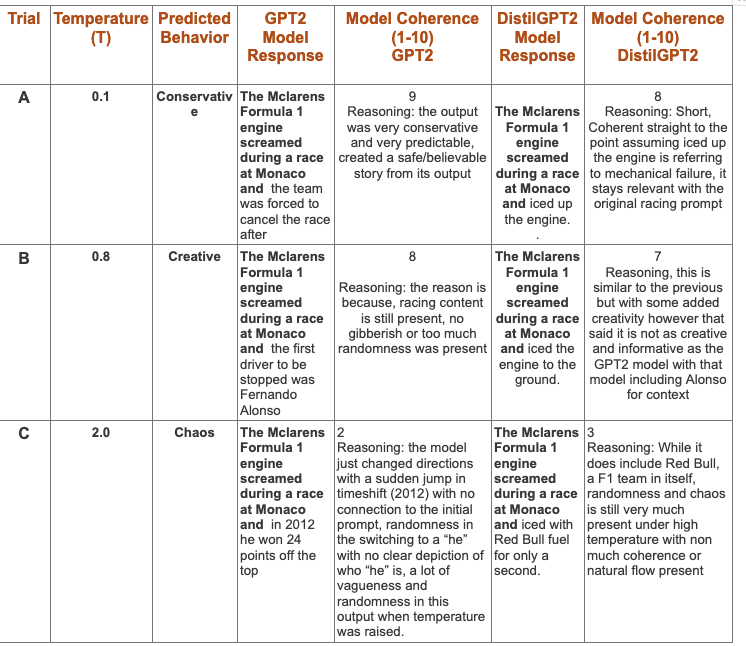